In [1]:
'''
Histogram features
'''
import os
import glob

base_dir = ["vehicles/", "non-vehicles/"]
car_non_car_files = ["cars.txt", "non-cars.txt"]

cars = []
non_cars = []

for i in range(2):
    image_types = os.listdir(base_dir[i])
    
    for imtype in image_types:
        if i == 0:
            cars.extend(glob.glob(base_dir[i]+imtype+"/*"))
        else:
            non_cars.extend(glob.glob(base_dir[i]+imtype+"/*"))
    
    with open(car_non_car_files[i], "w") as f:
        if i == 0:
            for path in cars:
                f.write(path+"\n")
        else:
            for path in non_cars:
                f.write(path+"\n")
            
print("Number of car images found = {}".format(len(cars)))
print("Number of non car images found = {}".format(len(non_cars)))


Number of car images found = 8792
Number of non car images found = 8968


In [2]:
# import packages

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img,
                            orientations=orient,
                            pixels_per_cell=(pix_per_cell, pix_per_cell),
                            cells_per_block=(cell_per_block, cell_per_block),
                            visualise=True,
                            feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img,
                            orientations=orient,
                            pixels_per_cell=(pix_per_cell, pix_per_cell),
                            cells_per_block=(cell_per_block, cell_per_block),
                            visualise=False,
                            feature_vector=feature_vec)
        return features

# Downsamples the image
def bin_spatial(img, size=(32, 32)):
    color0 = cv2.resize(img[:,:,0], size).ravel()
    color1 = cv2.resize(img[:,:,1], size).ravel()
    color2 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color0, color1, color2))


def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    c0_hist = np.histogram(img[:,:,0], bins=nbins)
    c1_hist = np.histogram(img[:,:,1], bins=nbins)
    c2_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((c0_hist[0], c1_hist[0], c2_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                     pix_per_cell = 8,
                     cell_per_block = 2,
                     hog_channel=0,
                     spatial_feat = True,
                     hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    for fname in imgs:
        file_features = []
        image = mpimg.imread(fname)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else:
                raise Error("Unsupported color space [{}]".format(color_space))
        else:
            feature_image = np.copy(image)
        
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat:
            hist_features = color_hist(feature_image, nbins = hist_bins)
            file_features.append(hist_features)
        if hog_feat:
            hog_features = []
            if hog_channel == 'ALL':
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                        orient,
                                                        pix_per_cell,
                                                        cell_per_block,
                                                        vis=False,
                                                        feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                    orient,
                                                    pix_per_cell,
                                                    cell_per_block,
                                                    vis=False,
                                                    feature_vec=True)
            file_features.append(hog_features)

        concatenated_file_features = np.concatenate(file_features)
        features.append(concatenated_file_features)
    return features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    
    x = x_start_stop[0]
    y = y_start_stop[0]

    while x + xy_window[0] <= x_start_stop[1]:
        while y + xy_window[1] <= y_start_stop[1]:
            window_list.append(((x,y), (x+xy_window[0], y+xy_window[1])))
            y += np.int((1-xy_overlap[1])*xy_window[1])
        y = y_start_stop[0]
        x += np.int((1-xy_overlap[0])*xy_window[0])

    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                       vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis:
                print
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

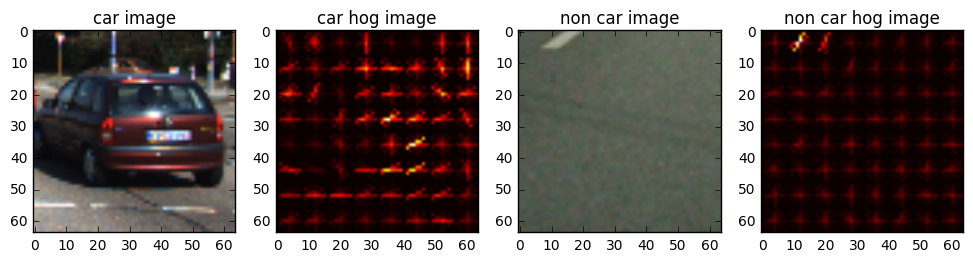

In [14]:
%matplotlib inline
car_ind = np.random.randint(0, len(cars))
non_car_ind = np.random.randint(0, len(non_cars))

car_image = mpimg.imread(cars[car_ind])
non_car_image = mpimg.imread(non_cars[non_car_ind])

color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space,
                                                 spatial_size = spatial_size,
                                                 hist_bins = 16, orient=orient,
                                                 pix_per_cell = pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,
                                                  hog_feat=hog_feat,
                                                  spatial_feat=spatial_feat,
                                                  hist_feat=hist_feat,
                                                  vis=True
                                                 )
non_car_features, non_car_hog_image = single_img_features(non_car_image, color_space=color_space,
                                                 spatial_size = spatial_size,
                                                 hist_bins = 16, orient=orient,
                                                 pix_per_cell = pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,
                                                  hog_feat=hog_feat,
                                                  spatial_feat=spatial_feat,
                                                  hist_feat=hist_feat,
                                                  vis=True
                                                 )
images = [car_image, car_hog_image, non_car_image, non_car_hog_image]
titles = ['car image', 'car hog image', 'non car image', 'non car hog image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [18]:
# Train the classifier
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = np.array(cars)[random_idxs]
random_idxs = np.random.randint(0, len(non_cars), n_samples)
test_non_cars = np.array(non_cars)[random_idxs]


car_features = extract_features(test_cars, color_space=color_space,
                               spatial_size=spatial_size,
                               hist_bins=hist_bins,
                               orient=orient,
                               pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block,
                               hog_channel=hog_channel,
                               spatial_feat=spatial_feat,
                               hist_feat=hist_feat,
                               hog_feat=hog_feat)

non_car_features = extract_features(test_non_cars, color_space=color_space,
                               spatial_size=spatial_size,
                               hist_bins=hist_bins,
                               orient=orient,
                               pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block,
                               hog_channel=hog_channel,
                               spatial_feat=spatial_feat,
                               hist_feat=hist_feat,
                               hog_feat=hog_feat)

print("Time to compute features = {} seconds".format(round(time.time()-t, 2)))

X = np.vstack((car_features, non_car_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.1, random_state=rand_state)
print("Using {} orientations, {} pixels per cell, {} cells per block, {} histogram bins, and {} spatial sampling".format(
orient, pix_per_cell, cell_per_block, hist_bins, spatial_size))
print("Feature vector length = {}".format(len(X_train[0])))

svc = LinearSVC()

t = time.time()
svc.fit(X_train, y_train)

print("Time to train SVC = {} seconds".format(round(time.time()-t, 2)))
print("Test accuracy = {}".format(round(svc.score(X_test, y_test), 4)))


Time to compute features = 310.34 seconds
Using 9 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector length = 8460
Time to train SVC = 403.23 seconds
Test accuracy = 0.9927


min pixel value = 0.0, max pixel value = 1.0
Time to process one image = 3.31 seconds, over windows = 100
min pixel value = 0.0, max pixel value = 1.0
Time to process one image = 1.65 seconds, over windows = 100
min pixel value = 0.0, max pixel value = 1.0
Time to process one image = 2.07 seconds, over windows = 100
min pixel value = 0.0, max pixel value = 1.0
Time to process one image = 1.82 seconds, over windows = 100
min pixel value = 0.0, max pixel value = 1.0
Time to process one image = 1.8 seconds, over windows = 100
min pixel value = 0.0, max pixel value = 1.0
Time to process one image = 1.68 seconds, over windows = 100
min pixel value = 0.0, max pixel value = 1.0
Time to process one image = 1.91 seconds, over windows = 100
min pixel value = 0.0, max pixel value = 1.0
Time to process one image = 1.85 seconds, over windows = 100


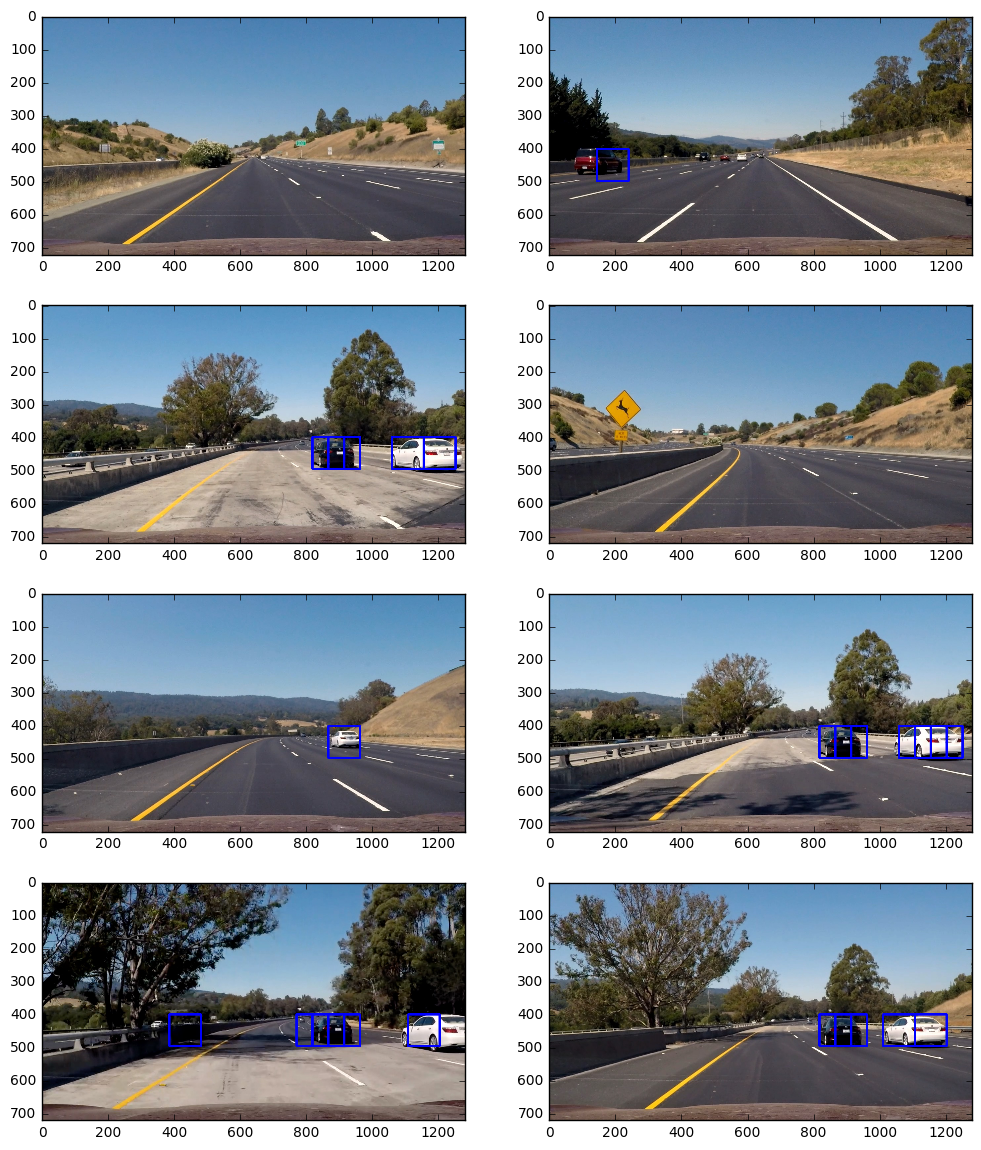

In [24]:
search_path = "vehicle_det_examples/*"
example_images = glob.glob(search_path)
images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5

for img_src in example_images:
    t = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print("min pixel value = {}, max pixel value = {}".format(np.min(img), np.max(img)))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(96, 96), xy_overlap = (overlap, overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                hog_feat=hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print("Time to process one image = {} seconds, over windows = {}".
          format(round(time.time()-t, 2), len(windows)))
fig=plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)